In [1]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine,cdist

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler



#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%reload_ext modeling

%matplotlib inline
%load_ext autoreload
%autoreload 2

try:
    remote_server="http://ec2-18-184-134-25.eu-central-1.compute.amazonaws.com"
    client = MlflowClient(remote_server)
    mlflow.set_tracking_uri(remote_server)
except ConnectionErrorrror as ConnErr:
    print("Could not reach remote MLflow service")
    client = MlflowClient()
    mlflow.set_experiment("Windowed Clustering")


In [2]:
df= utils.load_text_data("../data/2k_22-10.csv").head(2000)


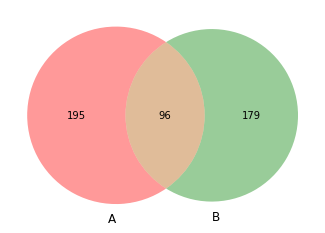

In [3]:
total = 240
overlap_ratio = 0.8
#df_a,df_b = df.head(total).sample(round(total*overlap_ratio)),df.head(total).sample(round(total*overlap_ratio))
df_a = df[(df.created_at.dt.day >= 20) & (df.created_at.dt.day <= 21)].sample(frac=0.7)
df_b = df[(df.created_at.dt.day >= 21) & (df.created_at.dt.day <= 22)].sample(frac=0.7)
sets = [set(df_a.index.values), set(df_b.index.values)]
venn2(sets)
print()

In [4]:
pdf_a = utils.preprocess_articles_for_bert(df_a,lower=True)
pdf_b = utils.preprocess_articles_for_bert(df_b,lower=True)

# Instead of spliting the data into two versions of the data just cluster twice the same data and then match them ...
unique_for_a= len(((sets[0] ^ sets[1]) & sets[0]) )
unique_for_b= len(((sets[0] ^ sets[1]) & sets[1]) )
common_for_both = len(sets[0] & sets[1])

In [7]:
#load BERT model from Hugging Face
#model_name= "T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
model_name= "T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb"
#model_name= "T-Systems-onsite/german-roberta-sentence-transformer-v2"

word_embedding_model = models.Transformer(model_name)
try:
    pass
    
    
    
except ConnectionError as ConnErr:
    print("Could not reach service")
    

In [8]:
embeddings_a = modeling.get_sentence_embeddings(pdf_a,word_embedding_model)
embeddings_b = modeling.get_sentence_embeddings(pdf_b,word_embedding_model)


--- Embedding dimension 768
--- 297 Documnets encoded 39.82370901107788 seconds ---



--- Embedding dimension 768
--- 276 Documnets encoded 37.62237095832825 seconds ---


In [16]:
N_COMPONENTS=128
alpha=0.7925
min_cluster_size=3
min_samples=3
n_neighbors=7

uamp_a, clusters_a = modeling.cluster_and_reduce(embeddings_a,n_components_clustering=N_COMPONENTS, min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                                 min_samples= min_samples,alpha=alpha)

uamp_b, clusters_b = modeling.cluster_and_reduce(embeddings_b,n_components_clustering=N_COMPONENTS,min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)

In [24]:
docs_df_a = utils.relink_data_after_clustering(uamp_a,df_a,clusters_a)
docs_df_b = utils.relink_data_after_clustering(uamp_b,df_b,clusters_b)


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_a_per_topic = docs_df_a.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    "article_uid":'count',
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                        "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                  }).set_index("topic_number")


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_b_per_topic = docs_df_b.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                     "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                  }).set_index("topic_number")



Outliers: 39 | Clustered: 258 | 0.8686868686868687 
 Cluster count: 52 
Outliers: 31 | Clustered: 245 | 0.8876811594202898 
 Cluster count: 41 


In [25]:
docs_a_per_topic.head()
#docs_df_b

,raw_text,headline,article_uid,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,,
-1,Kreißsaal oder Kracher? Bayern-Star Joshua Kim...,Flick hofft auf Papa Kimmich. Bill Cosby läche...,39,"[{'text': 'Kracher', 'type': 'OTHER'}, {'text'...","[{'text': 'Kracher', 'type': 'OTHER'}, {'text'...","[{'text': 'Kracher', 'type': 'OTHER'}, {'text'..."
0,Dresden – Sie gilt als Grand Dame der Akupunkt...,Frau Dr. eröffnet Praxis mit 70. Pfarrerin der...,4,"[{'text': 'Hause', 'type': 'LOCATION'}, {'text...","[{'text': 'Allergologie', 'type': 'OTHER'}, {'...","[{'text': 'Praxis', 'type': 'OTHER'}, {'text':..."
1,Saarbrücken/St. Wendel – Teilweise lange Schla...,Gesundheitsamt undCorona-Testzentrum überlaste...,6,"[{'text': 'Gesundheitsamt', 'type': 'ORGANIZAT...","[{'text': 'Messegelände', 'type': 'LOCATION'},...","[{'text': 'Gesundheitsamt', 'type': 'ORGANIZAT..."
2,Jetzt den Umweltbonus sichern. Immer mehr E-Au...,Alle Autos mit Umweltprämie. Wer jetzt Geld fü...,4,"[{'text': 'Zuschuss', 'type': 'OTHER'}, {'text...","[{'text': 'Umweltbonus', 'type': 'OTHER'}, {'t...","[{'text': 'Autos', 'type': 'CONSUMER_GOOD'}, {..."
3,Hannover - Ein kleiner Strich mit großer Wirku...,Hannover-Stars auf Leinwand. Helden vom Deichz...,4,"[{'text': 'Benefiz-Auktion', 'type': 'EVENT'},...","[{'text': 'Strich', 'type': 'OTHER'}, {'text':...","[{'text': 'Leinwand', 'type': 'OTHER'}, {'text..."


In [21]:
docs_b_per_topic.head()

,raw_text,headline,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,
-1,Niemand motzt so charmant wie Müller! Der Bay...,„Wir spielen gegen die größte Rabaukentruppe d...,"[{'text': 'Spruch', 'type': 'OTHER'}, {'text':...","[{'text': 'Niemand', 'type': 'PERSON'}, {'text...","[{'text': 'FC Bayern', 'type': 'ORGANIZATION'}..."
0,Das Endspiel hat gerade erst begonnen. Am Don...,Wird Becker am Donnerstag schon verurteilt?. H...,"[{'text': 'Boris', 'type': 'PERSON'}, {'text':...","[{'text': 'Endspiel', 'type': 'EVENT'}, {'text...","[{'text': 'Insolvenz-Prozes', 'type': 'OTHER'}..."
1,Kult-Komiker Sacha Baron Cohen (49) gelang vor...,Borat is back!. Nicht totzukriegen. Diana Hero...,"[{'text': 'borat 2', 'type': 'WORK_OF_ART'}, {...","[{'text': 'Welterfolg', 'type': 'OTHER'}, {'te...","[{'text': 'Prime', 'type': 'OTHER'}, {'text': ..."
2,„Vogue“-Chefin Anna Wintour und der Telekommun...,„Vogue“-ChefinAnna Wintour: Ehe-Aus!. Brexit-B...,"[{'text': 'Strahlen', 'type': 'OTHER'}, {'text...","[{'text': 'Telekommunikations-Millionär', 'typ...","[{'text': 'Vogue``-Chefin', 'type': 'OTHER'}, ..."
3,Es ist das wohl irrste Gerichtsurteil des Jahr...,Bisexueller Mann muss 3000 Euro an Ex-Frau zah...,"[{'text': 'Urteil', 'type': 'OTHER'}, {'text':...","[{'text': 'Gerichtsurteil', 'type': 'OTHER'}, ...","[{'text': 'Urteil', 'type': 'OTHER'}, {'text':..."


In [13]:
 ctrs=[]
for topic in docs_a_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON"]
    seo_title_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"] *3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:10]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_a_per_topic.index.values,ctrs)}   
merged_embeddings = modeling.get_sentence_embeddings(docs_a_per_topic["headline"].values,word_embedding_model,False)

cluster_labels_google_a = pd.DataFrame(
    zip(docs_a_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_a


--- Embedding dimension 768
--- 53 Documnets encoded 4.588299036026001 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Corona| alles| Bayern| Spiel| Trainer| Gäste| ...,"[0.42934084, -0.3185398, 0.2869035, -0.7306325..."
0,Frau| Dr.| Praxis| Bettina Hauswald| Hause| Dr...,"[-0.6280526, -0.4668714, 0.45640865, -0.729886..."
1,Corona| Mitarbeiter| Gesundheitsamt| Kreise| T...,"[1.2658052, -0.93422717, -0.38220352, 0.206609..."
2,Zuschuss| Geld| Ladesäulen| Autos| Umweltprämi...,"[-0.1458652, -0.33766598, 0.7747011, -0.291542..."
3,Stars| Hannover| Premiere| Need for Speed| Tas...,"[0.99881214, 0.35910395, 0.46010357, 0.4281058..."
4,Süßes| Luxus-Leben| Friseur| Franjo| Pfeil| Be...,"[0.36948416, -0.19960098, 0.47361317, 0.347834..."
5,Sauerland| Endausscheidungs-Kampf| München| Pi...,"[-0.42471504, -0.46319354, 1.1895636, -0.18331..."
6,Düsseldorf| Suchriesen| Google| US| Finanzkris...,"[0.26388937, -0.89298135, 1.0237751, -0.052468..."
7,Corona| Bayern| Atlético| Einblutung| OP| Spie...,"[-0.44344595, 0.16388074, 0.42397904, -0.23066..."


In [14]:
ctrs=[]
for topic in docs_b_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]
    seo_title_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"]*3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:10]
    ctrs.append(counted_word_occurances)
    
merged_embeddings = modeling.get_sentence_embeddings(docs_b_per_topic["headline"].values,word_embedding_model,False)
    
dict_with_top_words = {k:v  for k,v in  zip(docs_b_per_topic.index.values,ctrs)}   
cluster_labels_google_b = pd.DataFrame(
    zip(docs_b_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_b


--- Embedding dimension 768
--- 42 Documnets encoded 3.68966007232666 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Corona| Spiel| Real Madrid| Bayern| Hannover| ...,"[0.1149888, -0.035416543, 0.7812825, 0.2505938..."
0,Boris Becker| Gericht| Staatsanwältin| Becker|...,"[-0.9561972, 0.2935105, 0.4968207, -0.03943733..."
1,Prime| Erde| Kino| Borat| Fear| the Walking De...,"[-0.15341848, -0.89567614, 0.78986657, -0.9868..."
2,No-Deal-Scheidung| Judith Rakers| Zeitumstellu...,"[-0.4863078, -0.0042317063, 1.2926052, -0.6839..."
3,3000 Euro| Staatsanwalt| Mann| Angeklagte| Pro...,"[-1.275214, -0.014677565, 0.8713035, -0.146750..."
4,Mann| Polizei| Kunstwerk| Täter| Ausstellung| ...,"[-0.62313974, -1.2664682, 0.528328, -0.0648235..."
5,Foto| Botox| Let's Dance| Pietro Lombardi| Bil...,"[0.3064578, -0.31438094, 0.50103843, -0.798573..."
6,Corona| Pilot| Formel 1| Infektion| Stroll| Po...,"[0.24075782, 0.38913298, -0.0052436567, -0.101..."
7,Fahrer| Auto| Unfall| Zoos| Berufsverkehr| Aut...,"[-0.36428264, 0.25643846, 0.16523315, -0.50750..."


In [15]:
results_a = pd.merge(docs_df_a,cluster_labels_google_a.reset_index(),left_on="topic_number",right_on = "Topic")


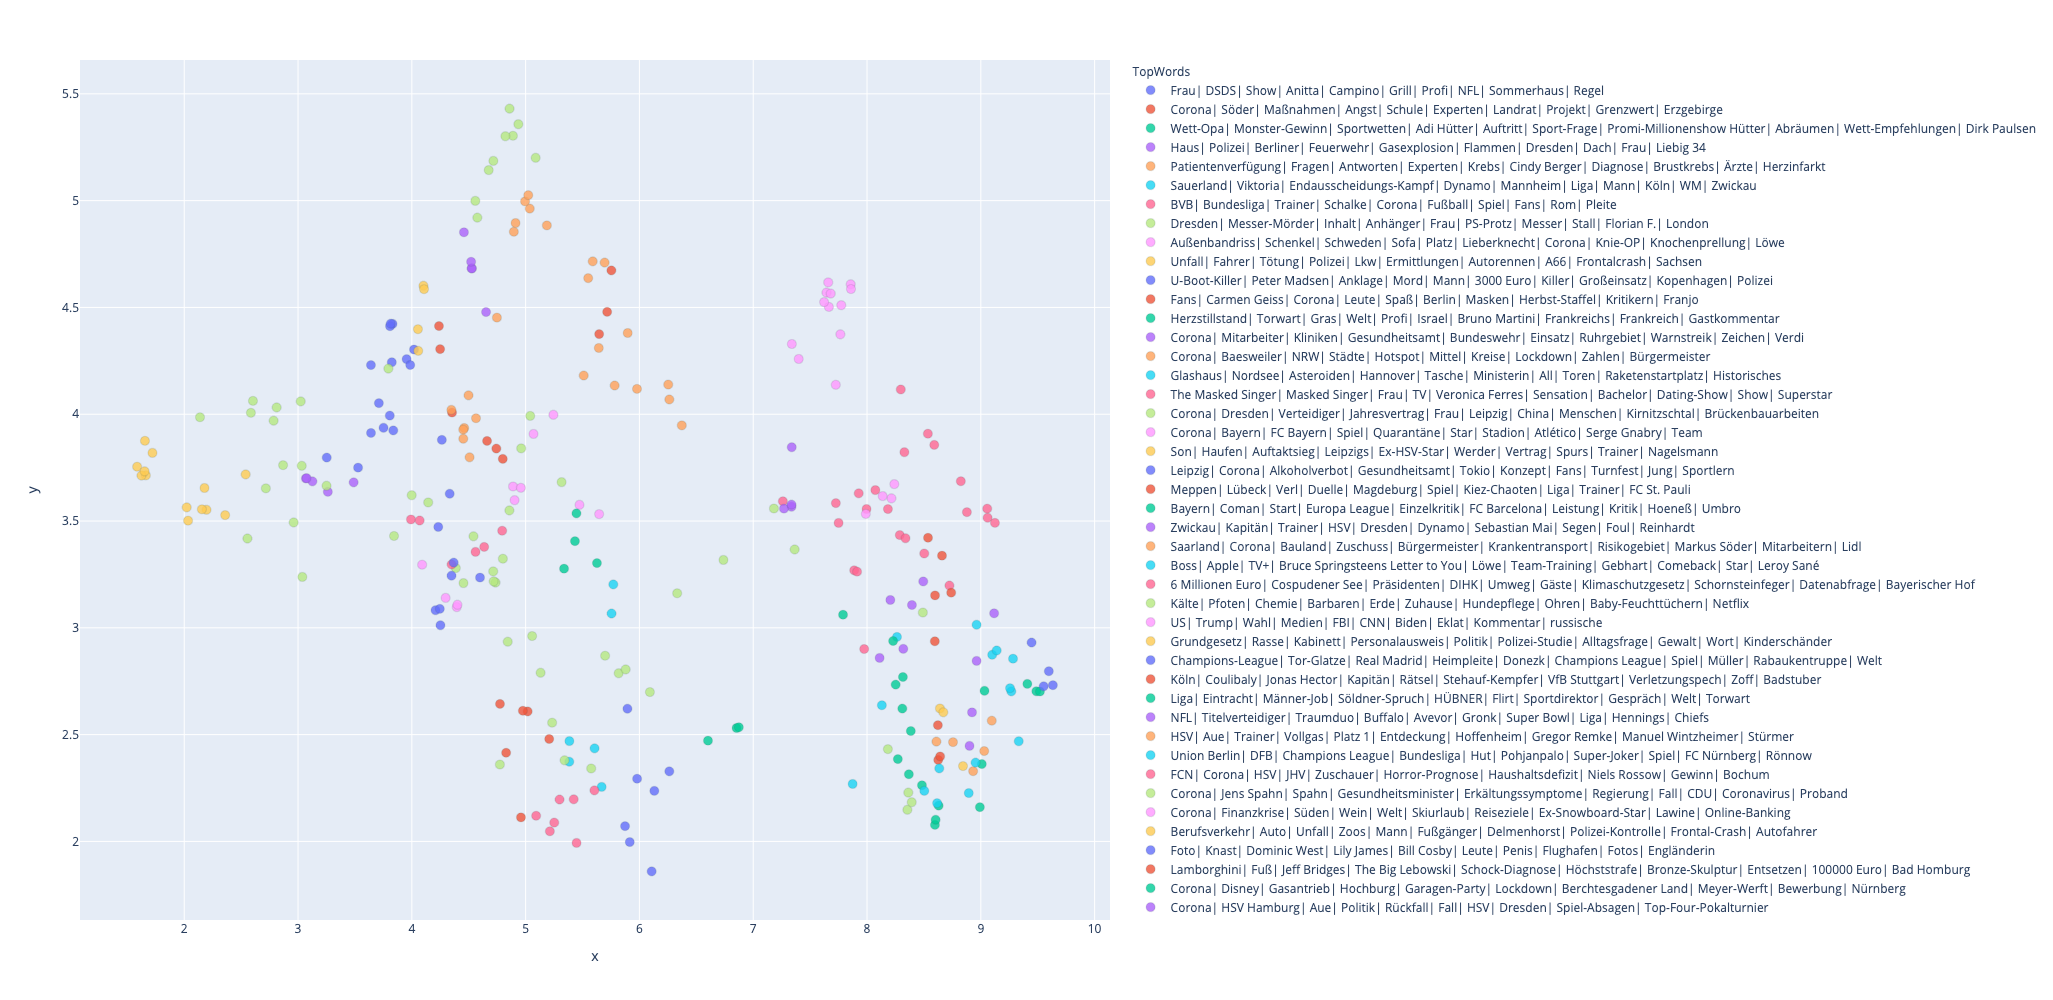

In [273]:
fig = px.scatter(results_a, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords",opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

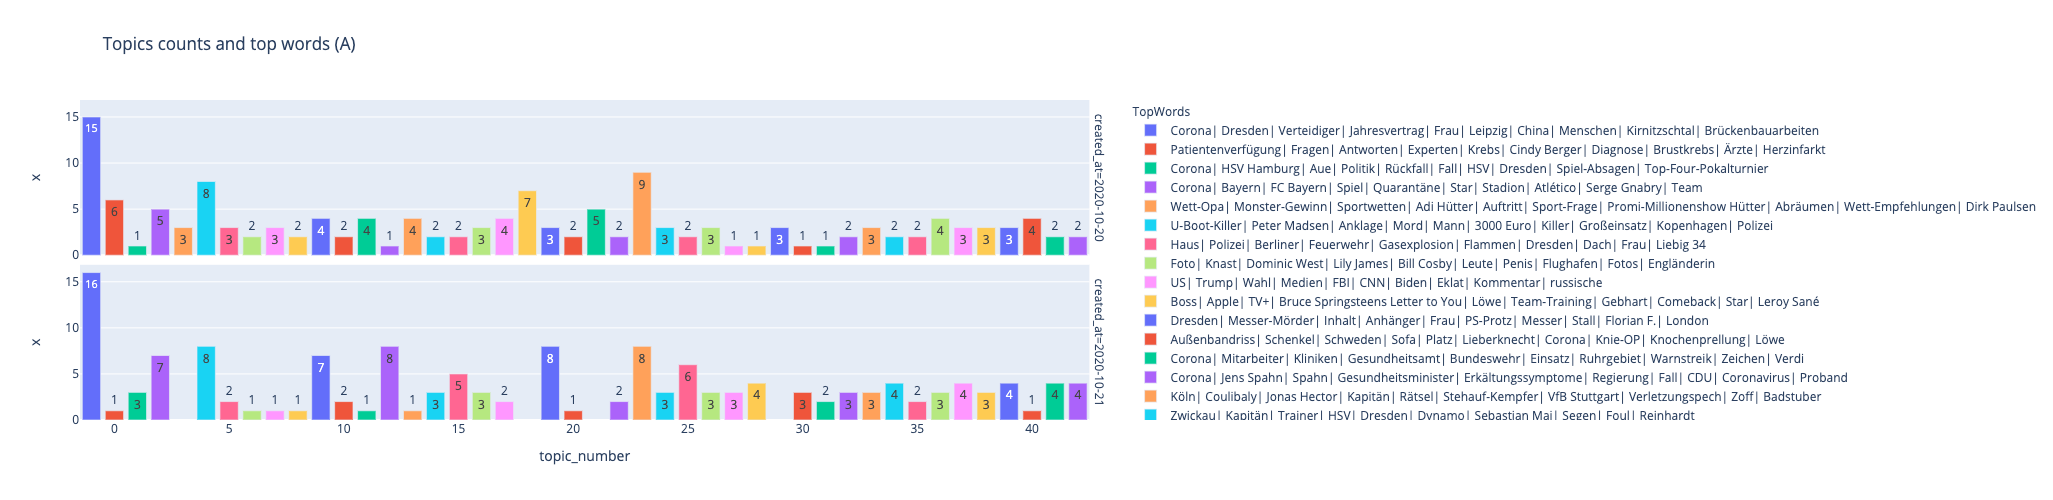

In [276]:

fig = px.bar(results_a.groupby(["created_at",'topic_number',"TopWords"]).count().reset_index(), x="topic_number", y="x", color="TopWords",hover_name="TopWords",
         title="Topics counts and top words (A)",facet_row="created_at",text="x")
fig.update_layout(
     height=500)

fig.show()

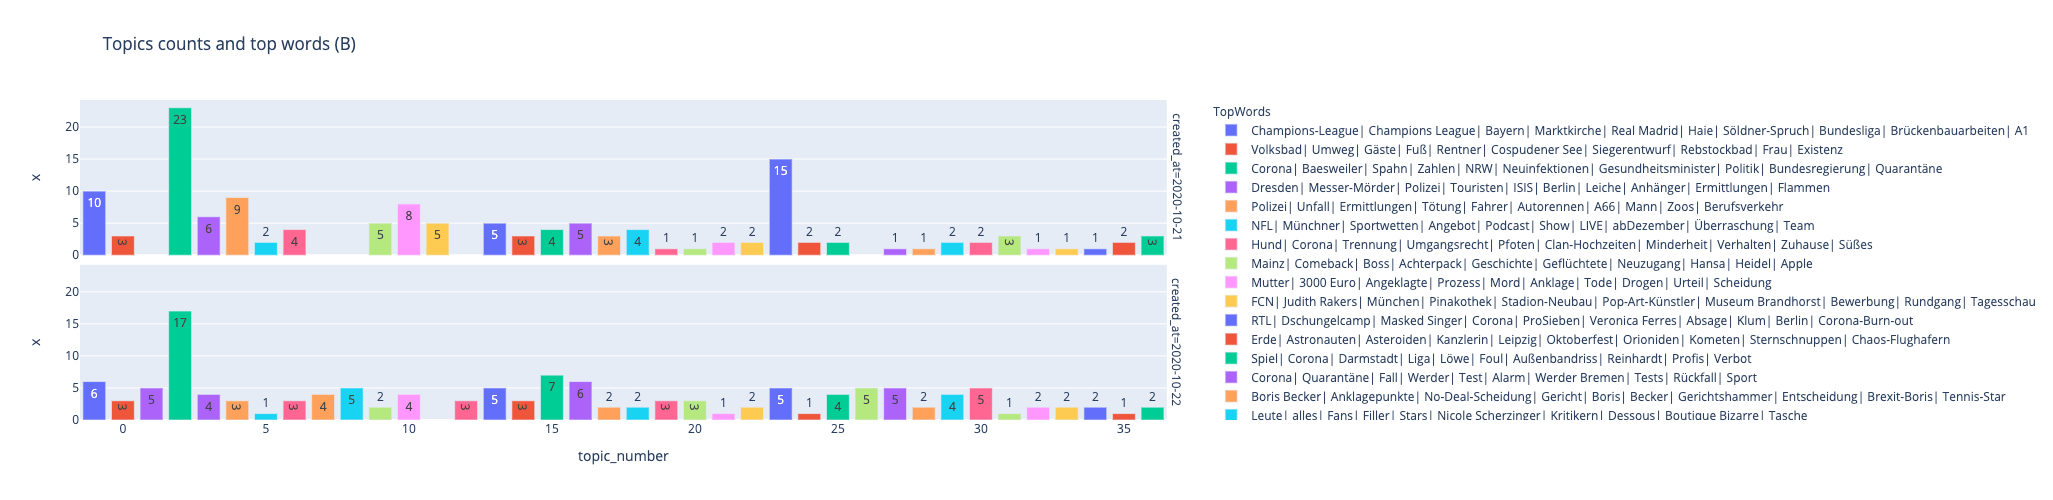

In [270]:
results_b=pd.merge(docs_df_b,cluster_labels_google_b.reset_index(),left_on="topic_number",right_on = "Topic")

fig = px.bar(results_b.groupby(["created_at",'topic_number',"TopWords"]).count().reset_index(), x="topic_number", y="x", color="topic_number",hover_name="TopWords",
         title="Topics counts and top words (B)",facet_row="created_at",text="x")
fig.update_layout(
     height=500)

fig.show()

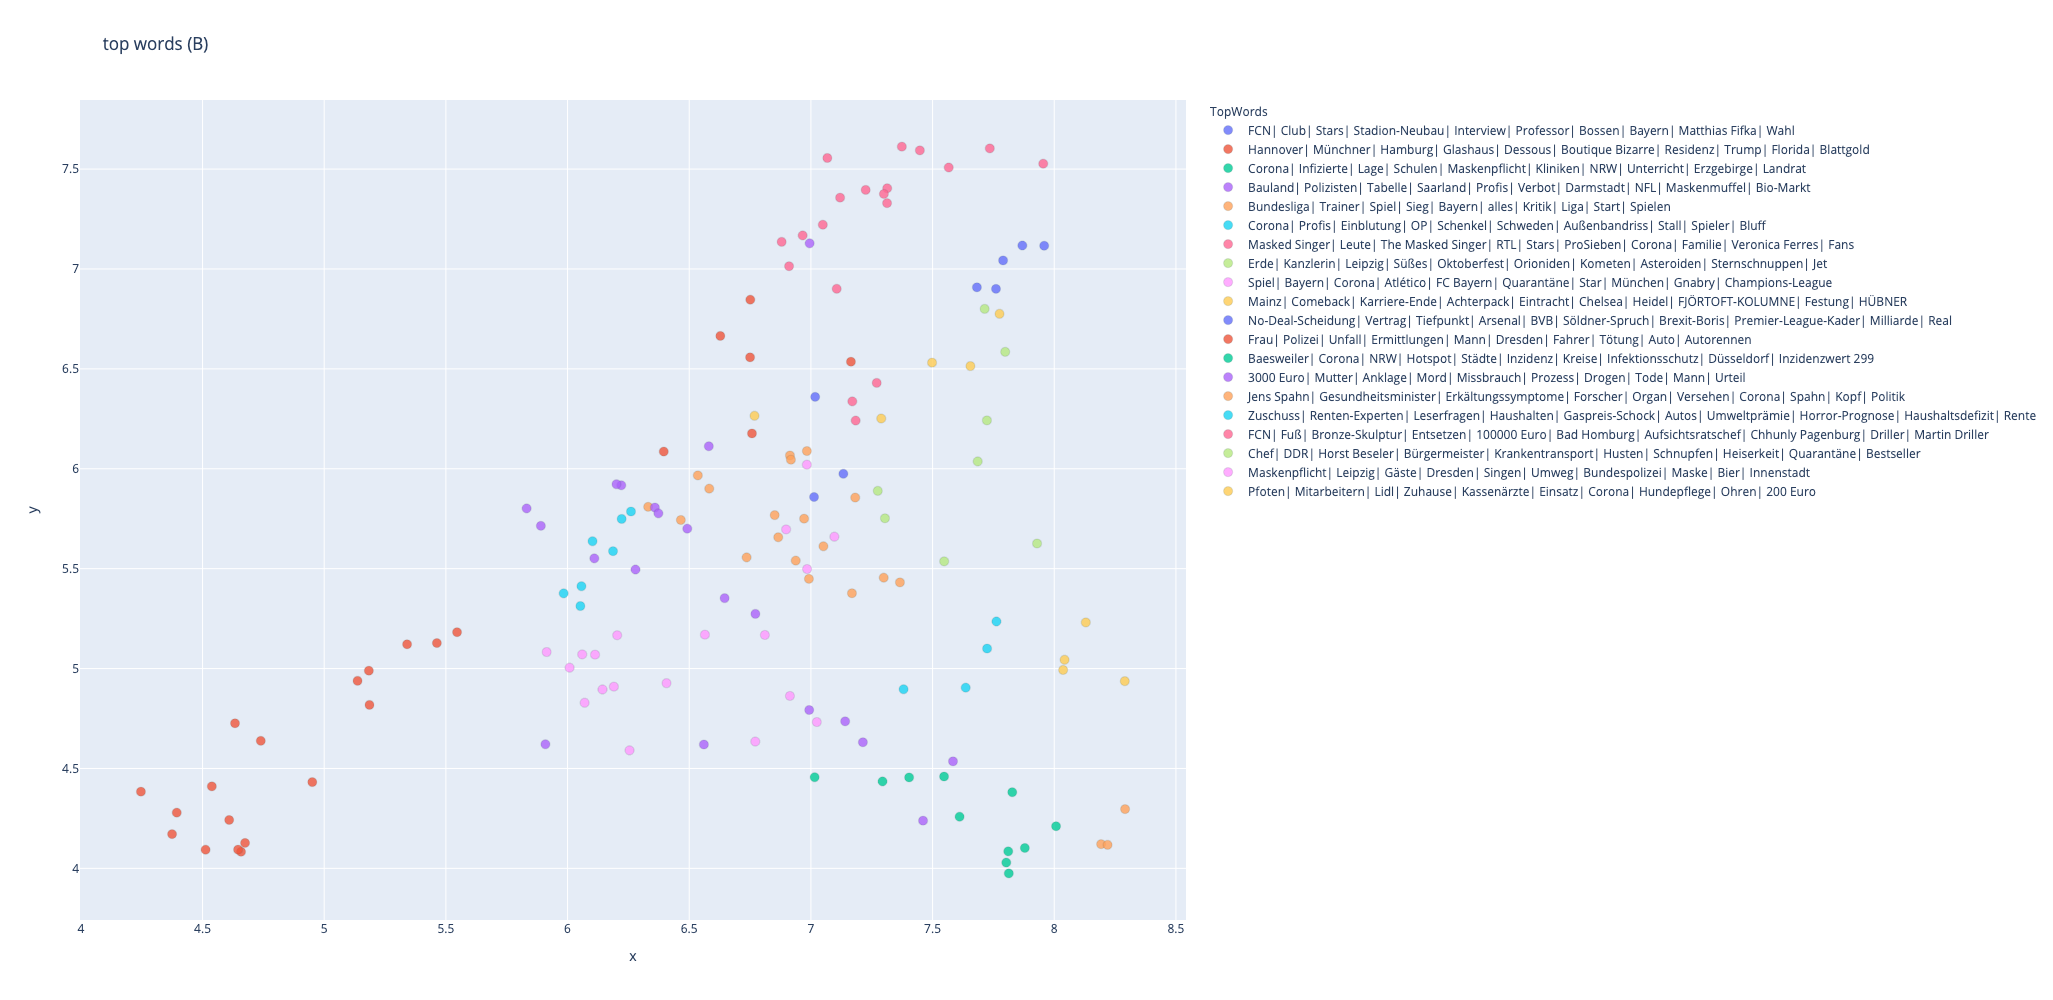

In [239]:

fig = px.scatter(results_b, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords", title="top words (B)",opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

In [240]:
cluster_labels_google_a.index.to_list()
data= cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine")

dist_matrix=pd.DataFrame(data,columns=cluster_labels_google_b.TopWords.to_list(),index=cluster_labels_google_a.TopWords.to_list()).style.highlight_min(color = 'lightgreen',axis = "rows")
dist_matrix

,Bauland| Polizisten| Tabelle| Saarland| Profis| Verbot| Darmstadt| NFL| Maskenmuffel| Bio-Markt,Masked Singer| Leute| The Masked Singer| RTL| Stars| ProSieben| Corona| Familie| Veronica Ferres| Fans,Bundesliga| Trainer| Spiel| Sieg| Bayern| alles| Kritik| Liga| Start| Spielen,Corona| Profis| Einblutung| OP| Schenkel| Schweden| Außenbandriss| Stall| Spieler| Bluff,Spiel| Bayern| Corona| Atlético| FC Bayern| Quarantäne| Star| München| Gnabry| Champions-League,No-Deal-Scheidung| Vertrag| Tiefpunkt| Arsenal| BVB| Söldner-Spruch| Brexit-Boris| Premier-League-Kader| Milliarde| Real,3000 Euro| Mutter| Anklage| Mord| Missbrauch| Prozess| Drogen| Tode| Mann| Urteil,Frau| Polizei| Unfall| Ermittlungen| Mann| Dresden| Fahrer| Tötung| Auto| Autorennen,FCN| Fuß| Bronze-Skulptur| Entsetzen| 100000 Euro| Bad Homburg| Aufsichtsratschef| Chhunly Pagenburg| Driller| Martin Driller,Pfoten| Mitarbeitern| Lidl| Zuhause| Kassenärzte| Einsatz| Corona| Hundepflege| Ohren| 200 Euro,FCN| Club| Stars| Stadion-Neubau| Interview| Professor| Bossen| Bayern| Matthias Fifka| Wahl,Mainz| Comeback| Karriere-Ende| Achterpack| Eintracht| Chelsea| Heidel| FJÖRTOFT-KOLUMNE| Festung| HÜBNER,Chef| DDR| Horst Beseler| Bürgermeister| Krankentransport| Husten| Schnupfen| Heiserkeit| Quarantäne| Bestseller,Zuschuss| Renten-Experten| Leserfragen| Haushalten| Gaspreis-Schock| Autos| Umweltprämie| Horror-Prognose| Haushaltsdefizit| Rente,Maskenpflicht| Leipzig| Gäste| Dresden| Singen| Umweg| Bundespolizei| Maske| Bier| Innenstadt,Erde| Kanzlerin| Leipzig| Süßes| Oktoberfest| Orioniden| Kometen| Asteroiden| Sternschnuppen| Jet,Hannover| Münchner| Hamburg| Glashaus| Dessous| Boutique Bizarre| Residenz| Trump| Florida| Blattgold,Corona| Infizierte| Lage| Schulen| Maskenpflicht| Kliniken| NRW| Unterricht| Erzgebirge| Landrat,Baesweiler| Corona| NRW| Hotspot| Städte| Inzidenz| Kreise| Infektionsschutz| Düsseldorf| Inzidenzwert 299,Jens Spahn| Gesundheitsminister| Erkältungssymptome| Forscher| Organ| Versehen| Corona| Spahn| Kopf| Politik
Köln| Clan-Hochzeiten| Minderheit| Verhalten| DFB| Achterpack| Stall| Spiel| Rönnow| Kobel,0.568034,0.506927,0.400472,0.290908,0.501487,0.602332,0.600365,0.599437,0.476547,0.655989,0.498557,0.431251,0.694814,0.733385,0.533249,0.689329,0.657149,0.678193,0.674663,0.751209
Unfall| Mann| Tötung| Polizei| Ermittlungen| 3000 Euro| Frau| Mutter| Staatsanwaltschaft| Mord,0.624520,0.630585,0.678007,0.704530,0.608185,0.773943,0.224029,0.303096,0.740190,0.655282,0.722503,0.693251,0.623994,0.793644,0.675114,0.651595,0.700592,0.757890,0.731241,0.796567
Corona| Jens Spahn| NRW| Baesweiler| Gesundheitsminister| Spahn| Regierung| Politik| Alarm| Antworten,0.421928,0.597640,0.574509,0.553274,0.575415,0.671211,0.674476,0.681430,0.661365,0.515446,0.577432,0.591179,0.529713,0.551282,0.640877,0.688018,0.707651,0.427360,0.540345,0.421647
Maskenpflicht| Schulen| Leipzig| Filialen| Douglas| Flammen| Leiche| Dresden| Singen| Pfoten,0.460685,0.718191,0.800798,0.708640,0.727067,0.837914,0.712765,0.585328,0.701019,0.538394,0.686837,0.764640,0.560706,0.685785,0.308411,0.616906,0.577639,0.532392,0.632873,0.777067
Leute| Masked Singer| The Masked Singer| Knast| RTL| ProSieben| Veronica Ferres| Fear| the Walking Dead| Prime,0.537019,0.186428,0.545195,0.535433,0.550277,0.628132,0.479422,0.523637,0.608255,0.624608,0.462906,0.516638,0.604648,0.716151,0.399104,0.338172,0.508543,0.642963,0.632575,0.768416
München| Judith Rakers| Boss| Pinakothek| FCN| Münchner| NFL| DDR| Horst Beseler| Stadion-Neubau,0.537644,0.462637,0.510093,0.480920,0.544883,0.510464,0.607512,0.595818,0.447243,0.740041,0.308738,0.395361,0.538080,0.593875,0.531922,0.518584,0.444387,0.721011,0.647751,0.725509
Corona| Aue| Politik| Süßes| Umweg| Gäste| Bundespolizei| Rückfall| Fall| Brückenbauarbeiten,0.682374,0.562538,0.597625,0.591068,0.535820,0.786200,0.717958,0.673234,0.627538,0.716763,0.515720,0.630001,0.752537,0.677111,0.277652,0.601241,0.644349,0.621508,0.668644,0.841611
Champions-League| Real Madrid| Cham

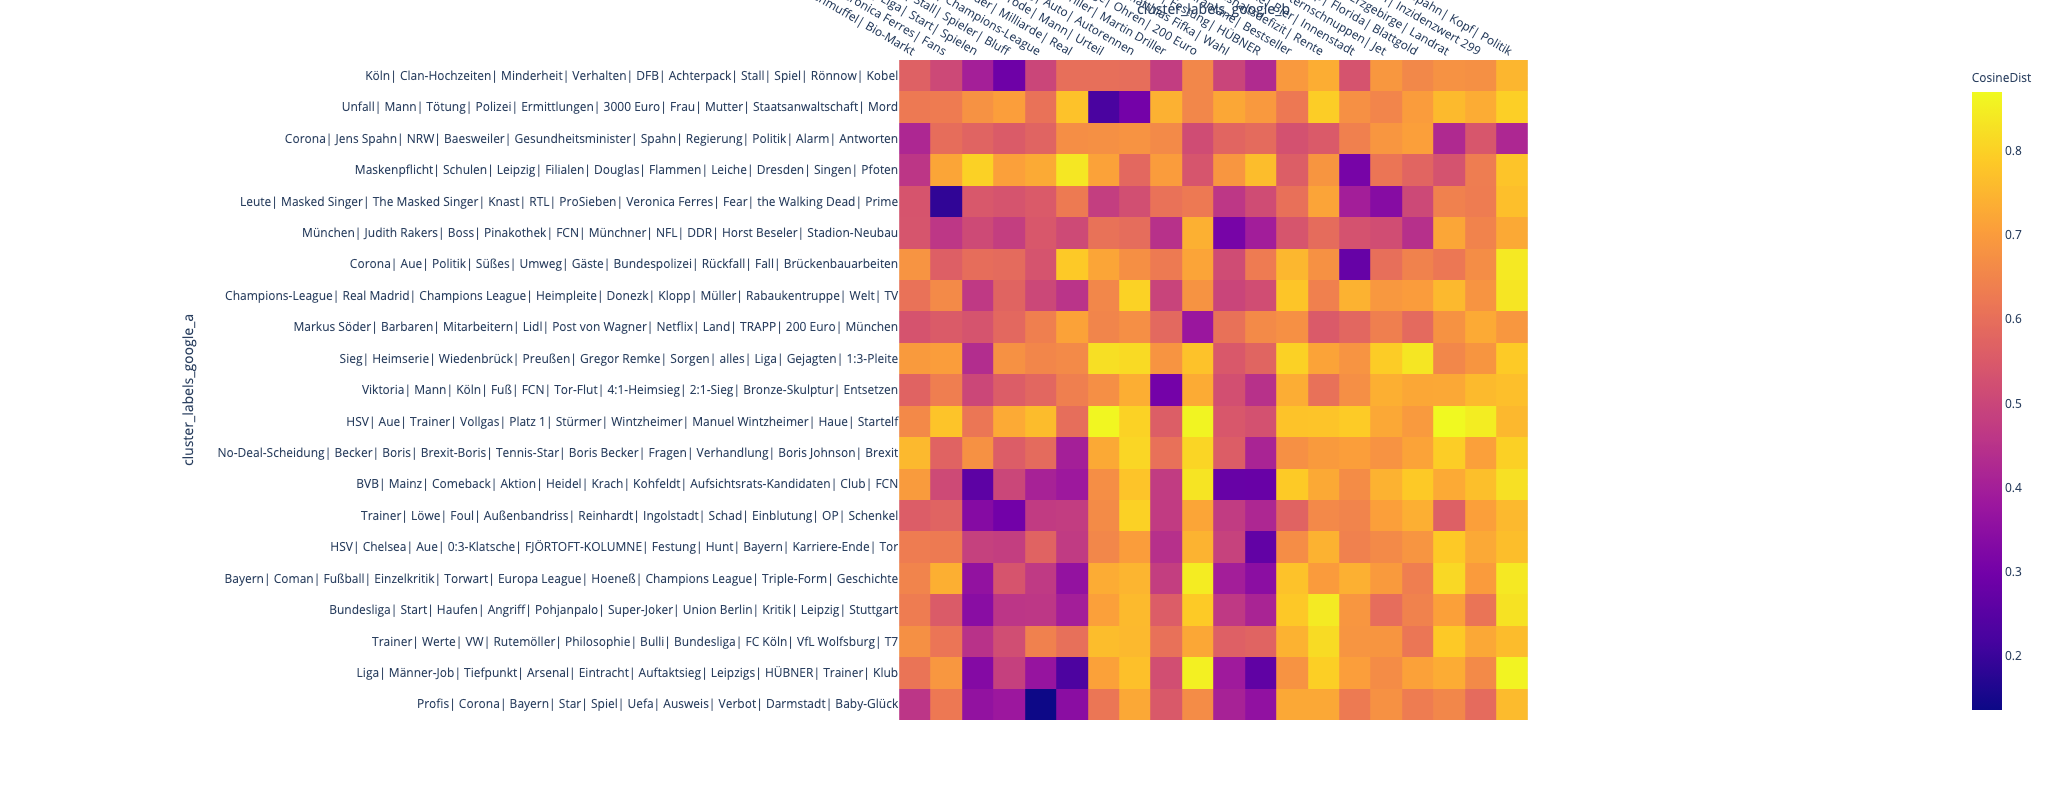

In [255]:
import plotly.express as px
fig = px.imshow(data,
                labels=dict(x="cluster_labels_google_b", y="cluster_labels_google_a", color="CosineDist"),
                x=cluster_labels_google_b.TopWords.to_list(),
                y=cluster_labels_google_a.TopWords.to_list()
               )
fig.update_xaxes(side="top")
fig.update_layout(height=800)

fig.show()

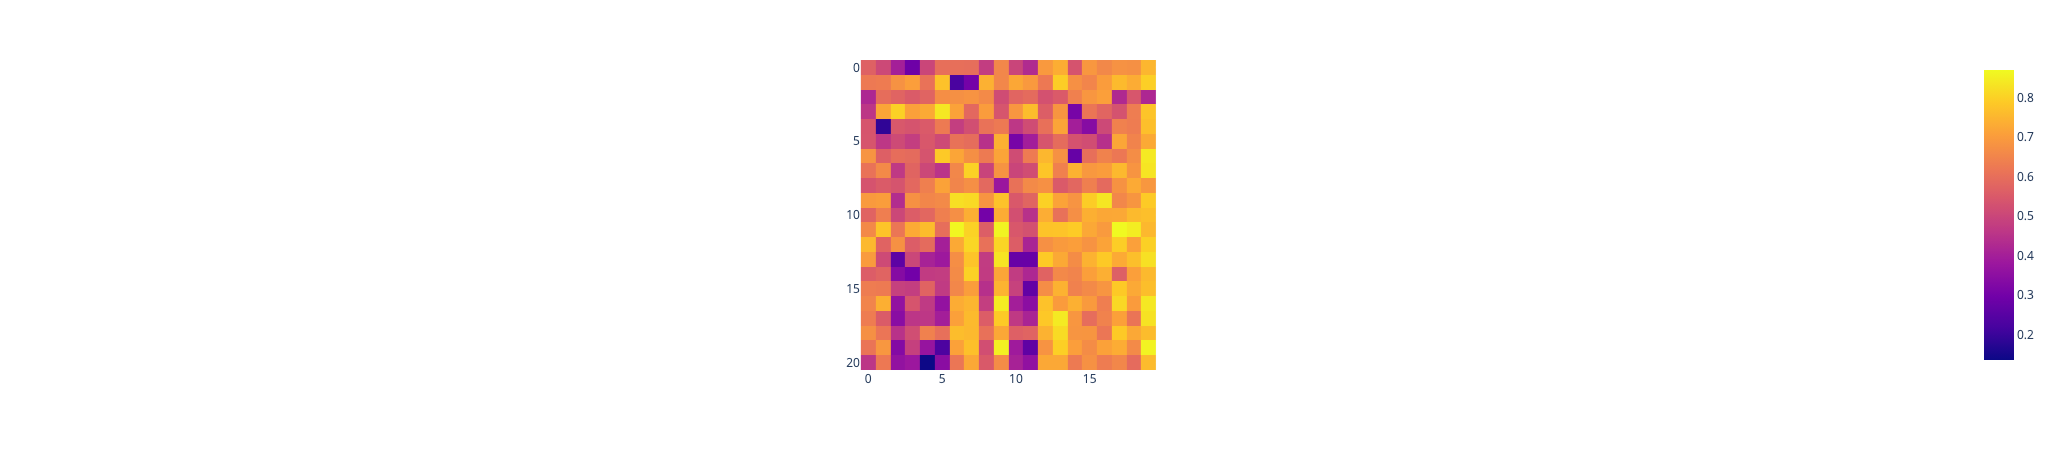

In [256]:

fig = px.imshow(cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine"))
fig.show()